In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import glob
import numpy as np
import os
import shutil
np.random.seed(0)

files = glob.glob('/content/drive/MyDrive/BUS_ROI2/*')

benign_files = [fn for fn in files if 'benign' in fn]
malignant_files = [fn for fn in files if 'malignant' in fn]
len(benign_files), len(malignant_files)

(1775, 931)

In [3]:
benign_train = np.random.choice(benign_files, size=1598, replace=False)
malignant_train = np.random.choice(malignant_files, size=838, replace=False)
benign_test = list(set(benign_files) - set(benign_train))#
malignant_test = list(set(malignant_files) - set(malignant_train))#
#print(len(benign_files),len(malignant_files))

benign_val = np.random.choice(benign_train, size=320, replace=False)
malignant_val = np.random.choice(malignant_train, size=168, replace=False)
benign_train = list(set(benign_train) - set(benign_val))
malignant_train = list(set(malignant_train) - set(malignant_val))

#malignant_files = list(set(malignant_files) - set(malignant_val))
#benign_test = np.random.choice(benign_files, size=90, replace=False)
#malignant_test = np.random.choice(malignant_files, size=90, replace=False)
print(len(benign_train),len(malignant_train),len(benign_val),len(malignant_val),len(benign_test),len(malignant_test))
#print('Benign datasets:', benign_train.shape, benign_val.shape, benign_test.shape)
#print('Malignant datasets:', malignant_train.shape, malignant_val.shape, malignant_test.shape)

1278 670 320 168 177 93


In [4]:
train_dir = 'training_data'
val_dir = 'validation_data'
test_dir = 'test_data'
import shutil
train_files = np.concatenate([benign_train, malignant_train])
validate_files = np.concatenate([benign_val, malignant_val])
test_files = np.concatenate([benign_test, malignant_test])

shutil.rmtree('training_data',ignore_errors=True)
shutil.rmtree('validation_data',ignore_errors=True)
shutil.rmtree('test_data',ignore_errors=True)
##
os.mkdir(train_dir) if not os.path.isdir(train_dir) else None
os.mkdir(val_dir) if not os.path.isdir(val_dir) else None
os.mkdir(test_dir) if not os.path.isdir(test_dir) else None

for fn in train_files:
    shutil.copy(fn, train_dir)

for fn in validate_files:
    shutil.copy(fn, val_dir)
    
for fn in test_files:
    shutil.copy(fn, test_dir)

In [5]:
files_tr = glob.glob('training_data/*')
files_vd = glob.glob('validation_data/*')
files_tt = glob.glob('test_data/*')
files_tr_benign = [fn for fn in files_tr if 'benign' in fn]
files_tr_malignant = [fn for fn in files_tr if 'malignant' in fn]

files_vd_benign = [fn for fn in files_vd if 'benign' in fn]
files_vd_malignant = [fn for fn in files_vd if 'malignant' in fn]

files_tt_benign = [fn for fn in files_tt if 'benign' in fn]
files_tt_malignant = [fn for fn in files_tt if 'malignant' in fn]
print('Files_tr:',len(files_tr_benign), len(files_tr_malignant))
print('Files_vd:',len(files_vd_benign), len(files_vd_malignant))
print('Files_tt:',len(files_tt_benign), len(files_tt_malignant))

Files_tr: 1278 670
Files_vd: 320 168
Files_tt: 177 93


PREPARING DATASET

In [6]:
import glob
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
%matplotlib inline
IMG_DIM = (150,150)

train_files = glob.glob('training_data/*')
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [fn.split('/')[1].split('.')[0].strip() for fn in train_files]

validation_files = glob.glob('validation_data/*')
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
validation_imgs = np.array(validation_imgs)
validation_labels = [fn.split('/')[1].split('.')[0].strip() for fn in validation_files]

test_files = glob.glob('test_data/*')
test_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in test_files]
test_imgs = np.array(test_imgs)
test_labels = [fn.split('/')[1].split('.')[0].strip() for fn in test_files]

print('Train dataset shape:', train_imgs.shape, 
      '\tValidation dataset shape:', validation_imgs.shape,'\tTest dataset shape:', test_imgs.shape)

Train dataset shape: (1948, 150, 150, 3) 	Validation dataset shape: (488, 150, 150, 3) 	Test dataset shape: (270, 150, 150, 3)


(150, 150, 3)


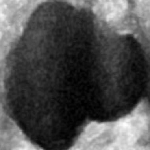

In [7]:
train_imgs_scaled = train_imgs.astype('float32')
validation_imgs_scaled  = validation_imgs.astype('float32')
test_imgs_scaled =test_imgs.astype('float32')
train_imgs_scaled /= 255
validation_imgs_scaled /= 255
test_imgs_scaled /= 255

print(train_imgs[0].shape)
array_to_img(train_imgs[0])

In [8]:
batch_size = 30
num_classes = 2
epochs = 30
input_shape = (150, 150, 3)

# encode text category labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)
test_labels_enc = le.transform(test_labels)

print(train_labels[25:30], train_labels_enc[25:30], test_labels_enc[25:30])

['benign', 'benign', 'benign', 'benign', 'malignant'] [0 0 0 0 1] [1 0 1 0 0]


In [9]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=20,brightness_range=[.5,1.5],
                                   width_shift_range=0, height_shift_range=0, shear_range=0, 
                                   horizontal_flip=True, fill_mode='constant')

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

Labels: ['benign', 'benign', 'benign', 'benign', 'benign']


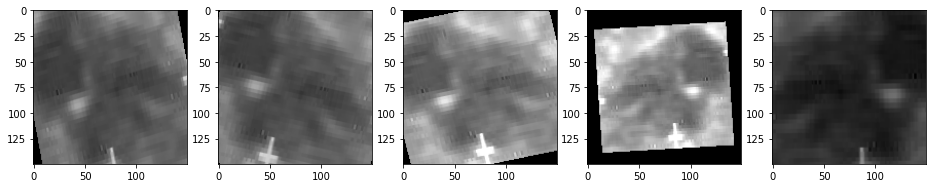

In [10]:
img_id = 6
bening_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1],
                                   batch_size=1)
bening = [next(bening_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in bening])
l = [ax[i].imshow(bening[i][0][0]) for i in range(0,5)]

Labels: ['benign', 'benign', 'benign', 'benign', 'benign']


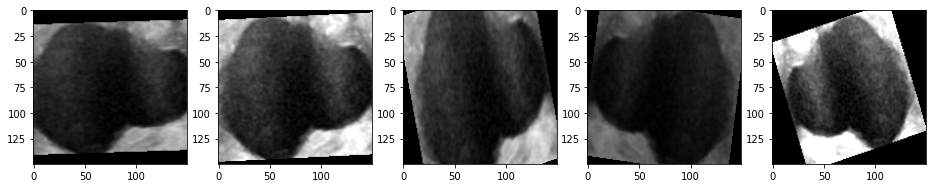

In [11]:
img_id = 0
malignant_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1],
                                   batch_size=1)
malignant = [next(malignant_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in malignant])
l = [ax[i].imshow(malignant[i][0][0]) for i in range(0,5)]

In [12]:
train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=30)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)
test_generator = test_datagen.flow(test_imgs, test_labels_enc, batch_size=20)
input_shape = (150, 150, 3)
TRAIN_STEPS_PER_EPOCH = np.ceil((len(train_imgs)/30)-1)
# to ensure that there are enough images for training bahch
VAL_STEPS_PER_EPOCH = np.ceil((len(validation_imgs)/20)-1)
print(TRAIN_STEPS_PER_EPOCH,VAL_STEPS_PER_EPOCH)

64.0 24.0


In [13]:
from keras.applications import vgg16
from keras.models import Model
import keras
import pandas as pd
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                                     input_shape=input_shape)

output = vgg.layers[-1].output
output = keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)

vgg_model.trainable = True

set_trainable = False
for layer in vgg_model.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
pd.set_option('max_colwidth', -1)

layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']) 



58892288/58889256 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


,Layer Type,Layer Name,Layer Trainable
0,<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f759dbda310>,input_1,False
1,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f759bd3e4d0>,block1_conv1,False
2,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f759bd44050>,block1_conv2,False
3,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f759010bdd0>,block1_pool,False
4,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f759010dcd0>,block2_conv1,False
5,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f759010fe90>,block2_conv2,False
6,<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f7590117fd0>,block2_pool,False
7,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f759011dd50>,block3_conv1,False
8,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f759011afd0>,block3_conv2,False
9,<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f7590124490>,block3_conv3,False


In [14]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers

model = Sequential()
model.add(vgg_model)
model.add(Dense(512, activation='relu', input_dim=input_shape))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer= optimizers.RMSprop(lr=1e-5),
              metrics=['accuracy'])
#optimizers.RMSprop(lr=1e-5)

In [15]:
import tensorflow_datasets as tfds
import pathlib
from matplotlib import pyplot
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import time
from keras.models import load_model
tic=time.time()

filepath='/content/drive/MyDrive/MODELOS/Vgg16/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5'
mc = ModelCheckpoint(filepath, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
es = [mc]
history= model.fit(train_generator, steps_per_epoch=TRAIN_STEPS_PER_EPOCH, epochs=100,
                              validation_data=val_generator, validation_steps=VAL_STEPS_PER_EPOCH, 
                              verbose=1, callbacks=[es])
print('Tiempo de procesamiento (secs): ', time.time()-tic)

#history = model.fit_generator(train_generator, steps_per_epoch=TRAIN_STEPS_PER_EPOCH, epochs=100,
 #                             validation_data=val_generator, validation_steps=VAL_STEPS_PER_EPOCH, 
 #                             verbose=1)    

Epoch 1/100
64/64 [==============================] - 55s 289ms/step - loss: 0.6520 - accuracy: 0.6230 - val_loss: 0.5222 - val_accuracy: 0.7417

Epoch 00001: val_accuracy improved from -inf to 0.74167, saving model to /content/drive/MyDrive/MODELOS/Vgg16/weights-improvement-01-0.74.hdf5
Epoch 2/100
64/64 [==============================] - 13s 208ms/step - loss: 0.5318 - accuracy: 0.7379 - val_loss: 0.5050 - val_accuracy: 0.7521

Epoch 00002: val_accuracy improved from 0.74167 to 0.75208, saving model to /content/drive/MyDrive/MODELOS/Vgg16/weights-improvement-02-0.75.hdf5
Epoch 3/100
64/64 [==============================] - 13s 209ms/step - loss: 0.5196 - accuracy: 0.7619 - val_loss: 0.4676 - val_accuracy: 0.7812

Epoch 00003: val_accuracy improved from 0.75208 to 0.78125, saving model to /content/drive/MyDrive/MODELOS/Vgg16/weights-improvement-03-0.78.hdf5
Epoch 4/100
64/64 [==============================] - 14s 211ms/step - loss: 0.4706 - accuracy: 0.7906 - val_loss: 0.4541 - val_acc

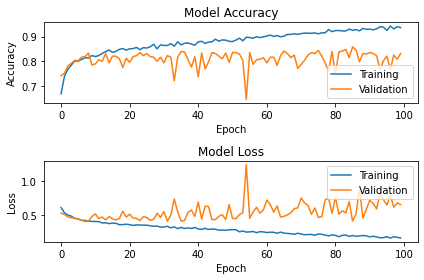

In [17]:

plt.figure(1)

# summarize history for accuracy

plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')

# summarize history for loss

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.tight_layout()

plt.show()

In [18]:
model.load_weights("/content/drive/MyDrive/MODELOS/Vgg16/weights-improvement-86-0.86.hdf5")
scores = model.evaluate(test_imgs_scaled, test_labels_enc, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

accuracy: 86.67%
